In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
from data import load_finches_2012, load_finches_1975
from utils import ECDF
import arviz as az

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In this notebook, I would like to write an estimation model for beak shape. 

In [2]:
df12 = load_finches_2012()
df12['shape'] = df12['beak_depth'] / df12['beak_length']

df12 = df12[df12['species'] != 'unknown']
df75 = load_finches_1975()

df = df12  # convenient alias

In [3]:
df12.head(5)

,band,species,beak_length,beak_depth,species_enc,shape
0,19022,fortis,10.0,8.5,0,0.850000
1,19028,fortis,12.5,8.9,0,0.712000
2,19032,fortis,9.3,7.5,0,0.806452
3,19041,fortis,10.3,9.6,0,0.932039
4,19044,fortis,11.0,9.2,0,0.836364


In [4]:
fortis_idx = df[df['species'] == 'fortis'].index
scandens_idx = df[df['species'] == 'scandens'].index

# Model : Naive Division of Posteriors

- Estimate posterior for depth and length independently.
- Use posterior samples to estimate distribution for shape.

In [5]:
# Mega-model incorporating shape as well. 
# We will also analyze the SD in addition to the mean.

with pm.Model() as beak_model:
    # SD can only be positive, therefore it is reasonable to constrain to >0
    # Likewise for betas.
    sd_hyper = pm.HalfCauchy('sd_hyper', beta=100, shape=(2,))
    beta_hyper = pm.HalfCauchy('beta_hyper', beta=100, shape=(2,))
    
    # Beaks cannot be of "negative" mean, therefore, HalfNormal is 
    # a reasonable, constrained prior.
    mean_depth = pm.HalfNormal('mean_depth', sd=sd_hyper[0], shape=(2,))
    sd_depth = pm.HalfCauchy('sd_depth', beta=beta_hyper[0], shape=(2,))
    
    mean_length = pm.HalfNormal('mean_length', sd=sd_hyper[1], shape=(2,))
    sd_length = pm.HalfCauchy('sd_length', beta=beta_hyper[1], shape=(2,))

    nu = pm.Exponential('nu', lam=1/29.) + 1
    
    # Define the likelihood distribution for the data.
    depth = pm.StudentT('beak_depth', 
                        nu=nu,
                        mu=mean_depth[df['species_enc']], 
                        sd=sd_depth[df['species_enc']], 
                        observed=df['beak_depth'])
    
    length = pm.StudentT('beak_length',
                         nu=nu,
                         mu=mean_length[df['species_enc']],
                         sd=sd_length[df['species_enc']],
                         observed=df['beak_length'])

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [6]:
with beak_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sd_length, mean_length, sd_depth, mean_depth, beta_hyper, sd_hyper]
Sampling 4 chains:   0%|          | 0/10000 [00:00<?, ?draws/s]/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c909f4978>,
      dtype=object)

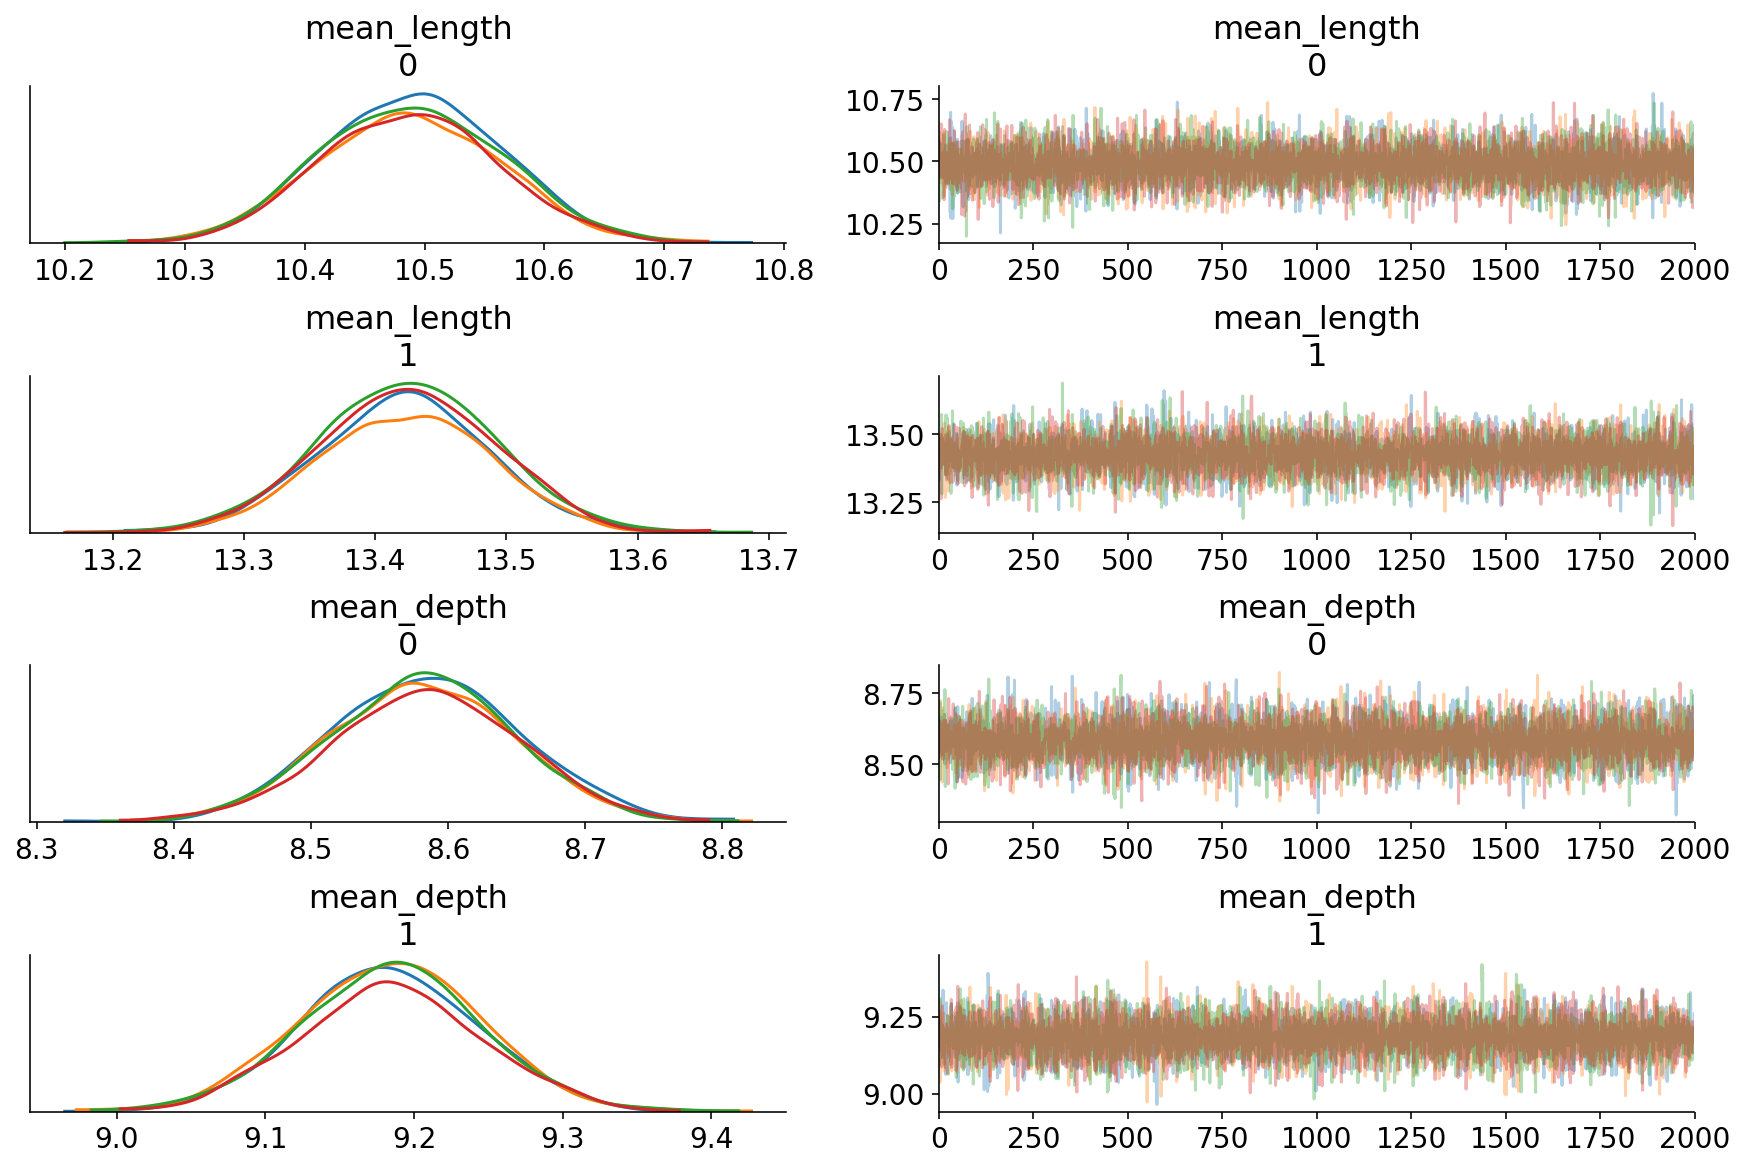

In [7]:
az.plot_trace(trace, var_names=['mean_length', 'mean_depth'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c90019fd0>,
      dtype=object)

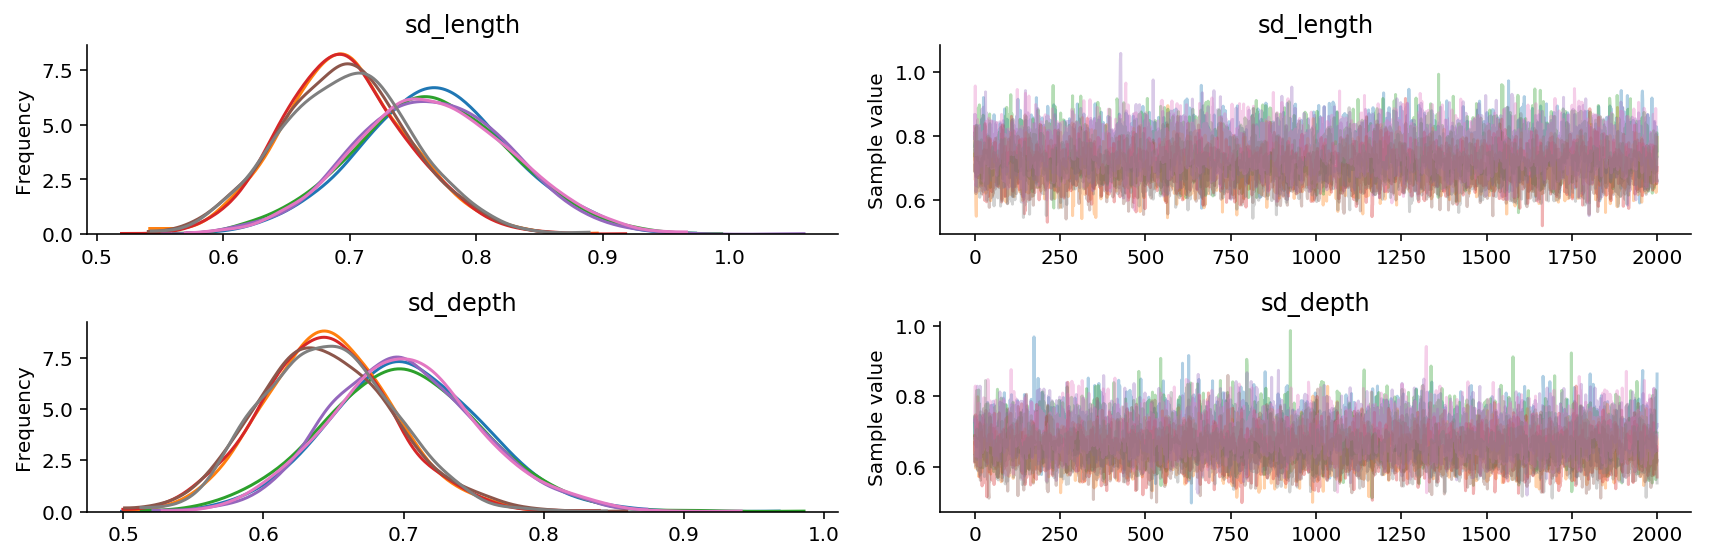

In [8]:
pm.traceplot(trace, varnames=['sd_length', 'sd_depth'])

In [9]:
samples = pm.sample_ppc(trace, model=beak_model)
samples

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
  0%|          | 0/8000 [00:00<?, ?it/s]/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be int

{'beak_depth': array([[8.00822342, 9.29941582, 9.15566821, ..., 9.672332  , 9.85556066,
         9.42055625],
        [8.02084429, 8.40477516, 8.6933044 , ..., 9.45545622, 8.50699099,
         9.41567568],
        [8.90705415, 8.80254575, 8.65111339, ..., 9.02638406, 8.64378254,
         9.55874019],
        ...,
        [8.63369094, 9.24466123, 8.67610449, ..., 7.96808403, 9.57178552,
         9.02224262],
        [7.66848612, 9.3547937 , 9.31045791, ..., 8.75123082, 9.30015557,
         9.37193603],
        [7.57902997, 8.87471562, 8.29201328, ..., 8.75780826, 9.59574497,
         9.52091288]]),
 'beak_length': array([[12.16094768, 11.18462942, 10.19116554, ..., 13.30954923,
         12.86764613, 13.34927396],
        [11.4398119 , 10.13747827, 10.19520274, ..., 14.1651593 ,
         11.34762314, 13.31015092],
        [10.14550359, 10.62738747, 11.09320496, ..., 13.67289963,
         13.14719199, 12.15454003],
        ...,
        [ 9.88003606,  9.43344829,  9.38762093, ..., 11.98201

PPC check for Fortis

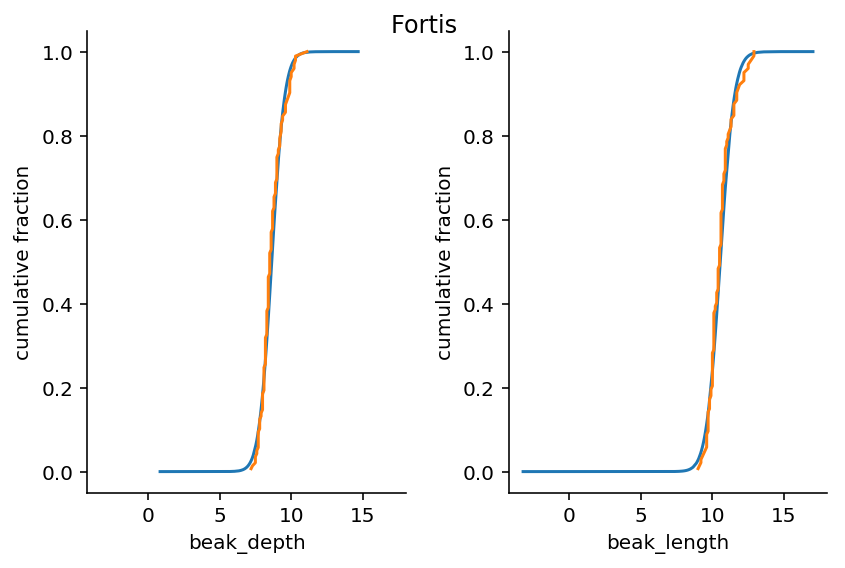

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex=ax1)

def plot_ppc_data(samples, df, idxs, column, ax):
    x, y = ECDF(samples[column][:, idxs].flatten())
    ax.plot(x, y, label='ppc')
    x, y = ECDF(df.iloc[idxs][column])
    ax.plot(x, y, label='data')
    ax.set_xlabel(column)
    ax.set_ylabel('cumulative fraction')
    return ax

ax1 = plot_ppc_data(samples, df, fortis_idx, 'beak_depth', ax1)
ax2 = plot_ppc_data(samples, df, fortis_idx, 'beak_length', ax2)

fig.suptitle('Fortis')
plt.tight_layout()

PPC check for Scandens

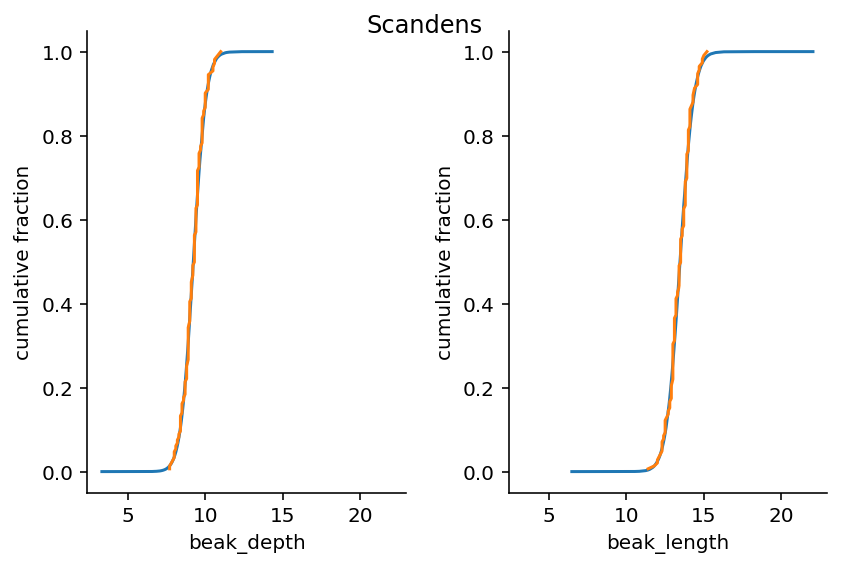

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex=ax1)

ax1 = plot_ppc_data(samples, df, scandens_idx, 'beak_depth', ax1)
ax2 = plot_ppc_data(samples, df, scandens_idx, 'beak_length', ax2)

fig.suptitle('Scandens')
plt.tight_layout()

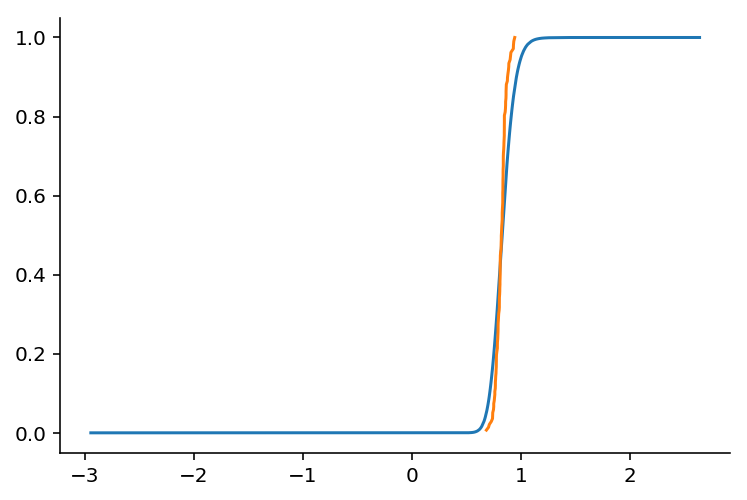

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
x, y = ECDF((samples['beak_depth'][:, fortis_idx] / samples['beak_length'][:, fortis_idx]).flatten())
ax.plot(x, y)
x, y = ECDF(df.loc[fortis_idx, 'shape'])
ax.plot(x, y)

Ok, looks like this is not the right model. Dividing PPC samples is definitely not the right approach here.

Maybe jointly modelling the observed beak and length distributions is the right thing to do?

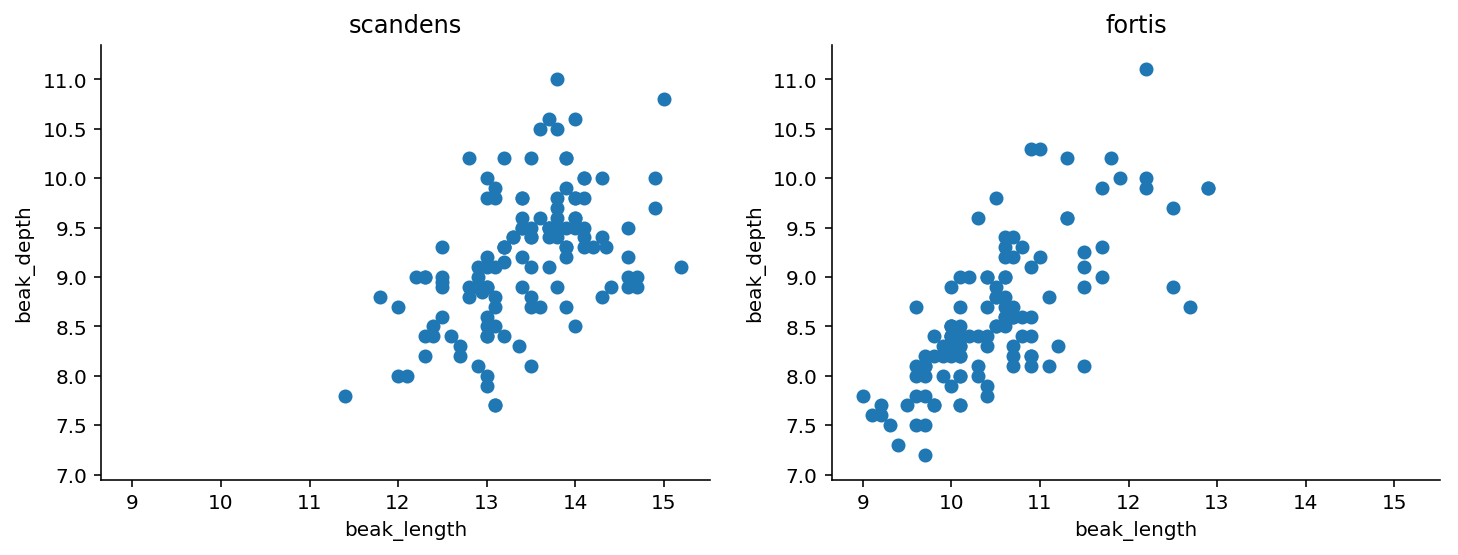

In [13]:
fig = plt.figure(figsize=(12, 4))

def plot_length_depth_scatter(df, idxs, title, ax):
    ax.scatter(df.iloc[idxs]['beak_length'], df.iloc[idxs]['beak_depth'])
    ax.set_xlabel('beak_length')
    ax.set_ylabel('beak_depth')
    ax.set_title(title)
    return ax


ax1 = fig.add_subplot(121)
ax1 = plot_length_depth_scatter(df, scandens_idx, 'scandens', ax1)

ax2 = fig.add_subplot(122, sharex=ax1, sharey=ax1)
ax2 = plot_length_depth_scatter(df, fortis_idx, 'fortis', ax2)


# Model: Joint Distribution

Going to try a new model: we explicity model depth and length jointly, as a multivariate gaussian.

In [14]:
with pm.Model() as mv_beaks:  # multivariate beak model
    packed_L = pm.LKJCholeskyCov('packed_L', n=2,
                             eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
    L = pm.expand_packed_triangular(2, packed_L)
    sigma = pm.Deterministic('sigma', L.dot(L.T))

    mu = pm.HalfNormal('mu', sd=20, shape=(2,))
    
    like = pm.MvNormal('like', mu=mu, cov=sigma, observed=df.iloc[scandens_idx][['beak_depth', 'beak_length']].values)

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [15]:
with mv_beaks:
    trace_mv = pm.sample(2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tenso

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c915882e8>,
      dtype=object)

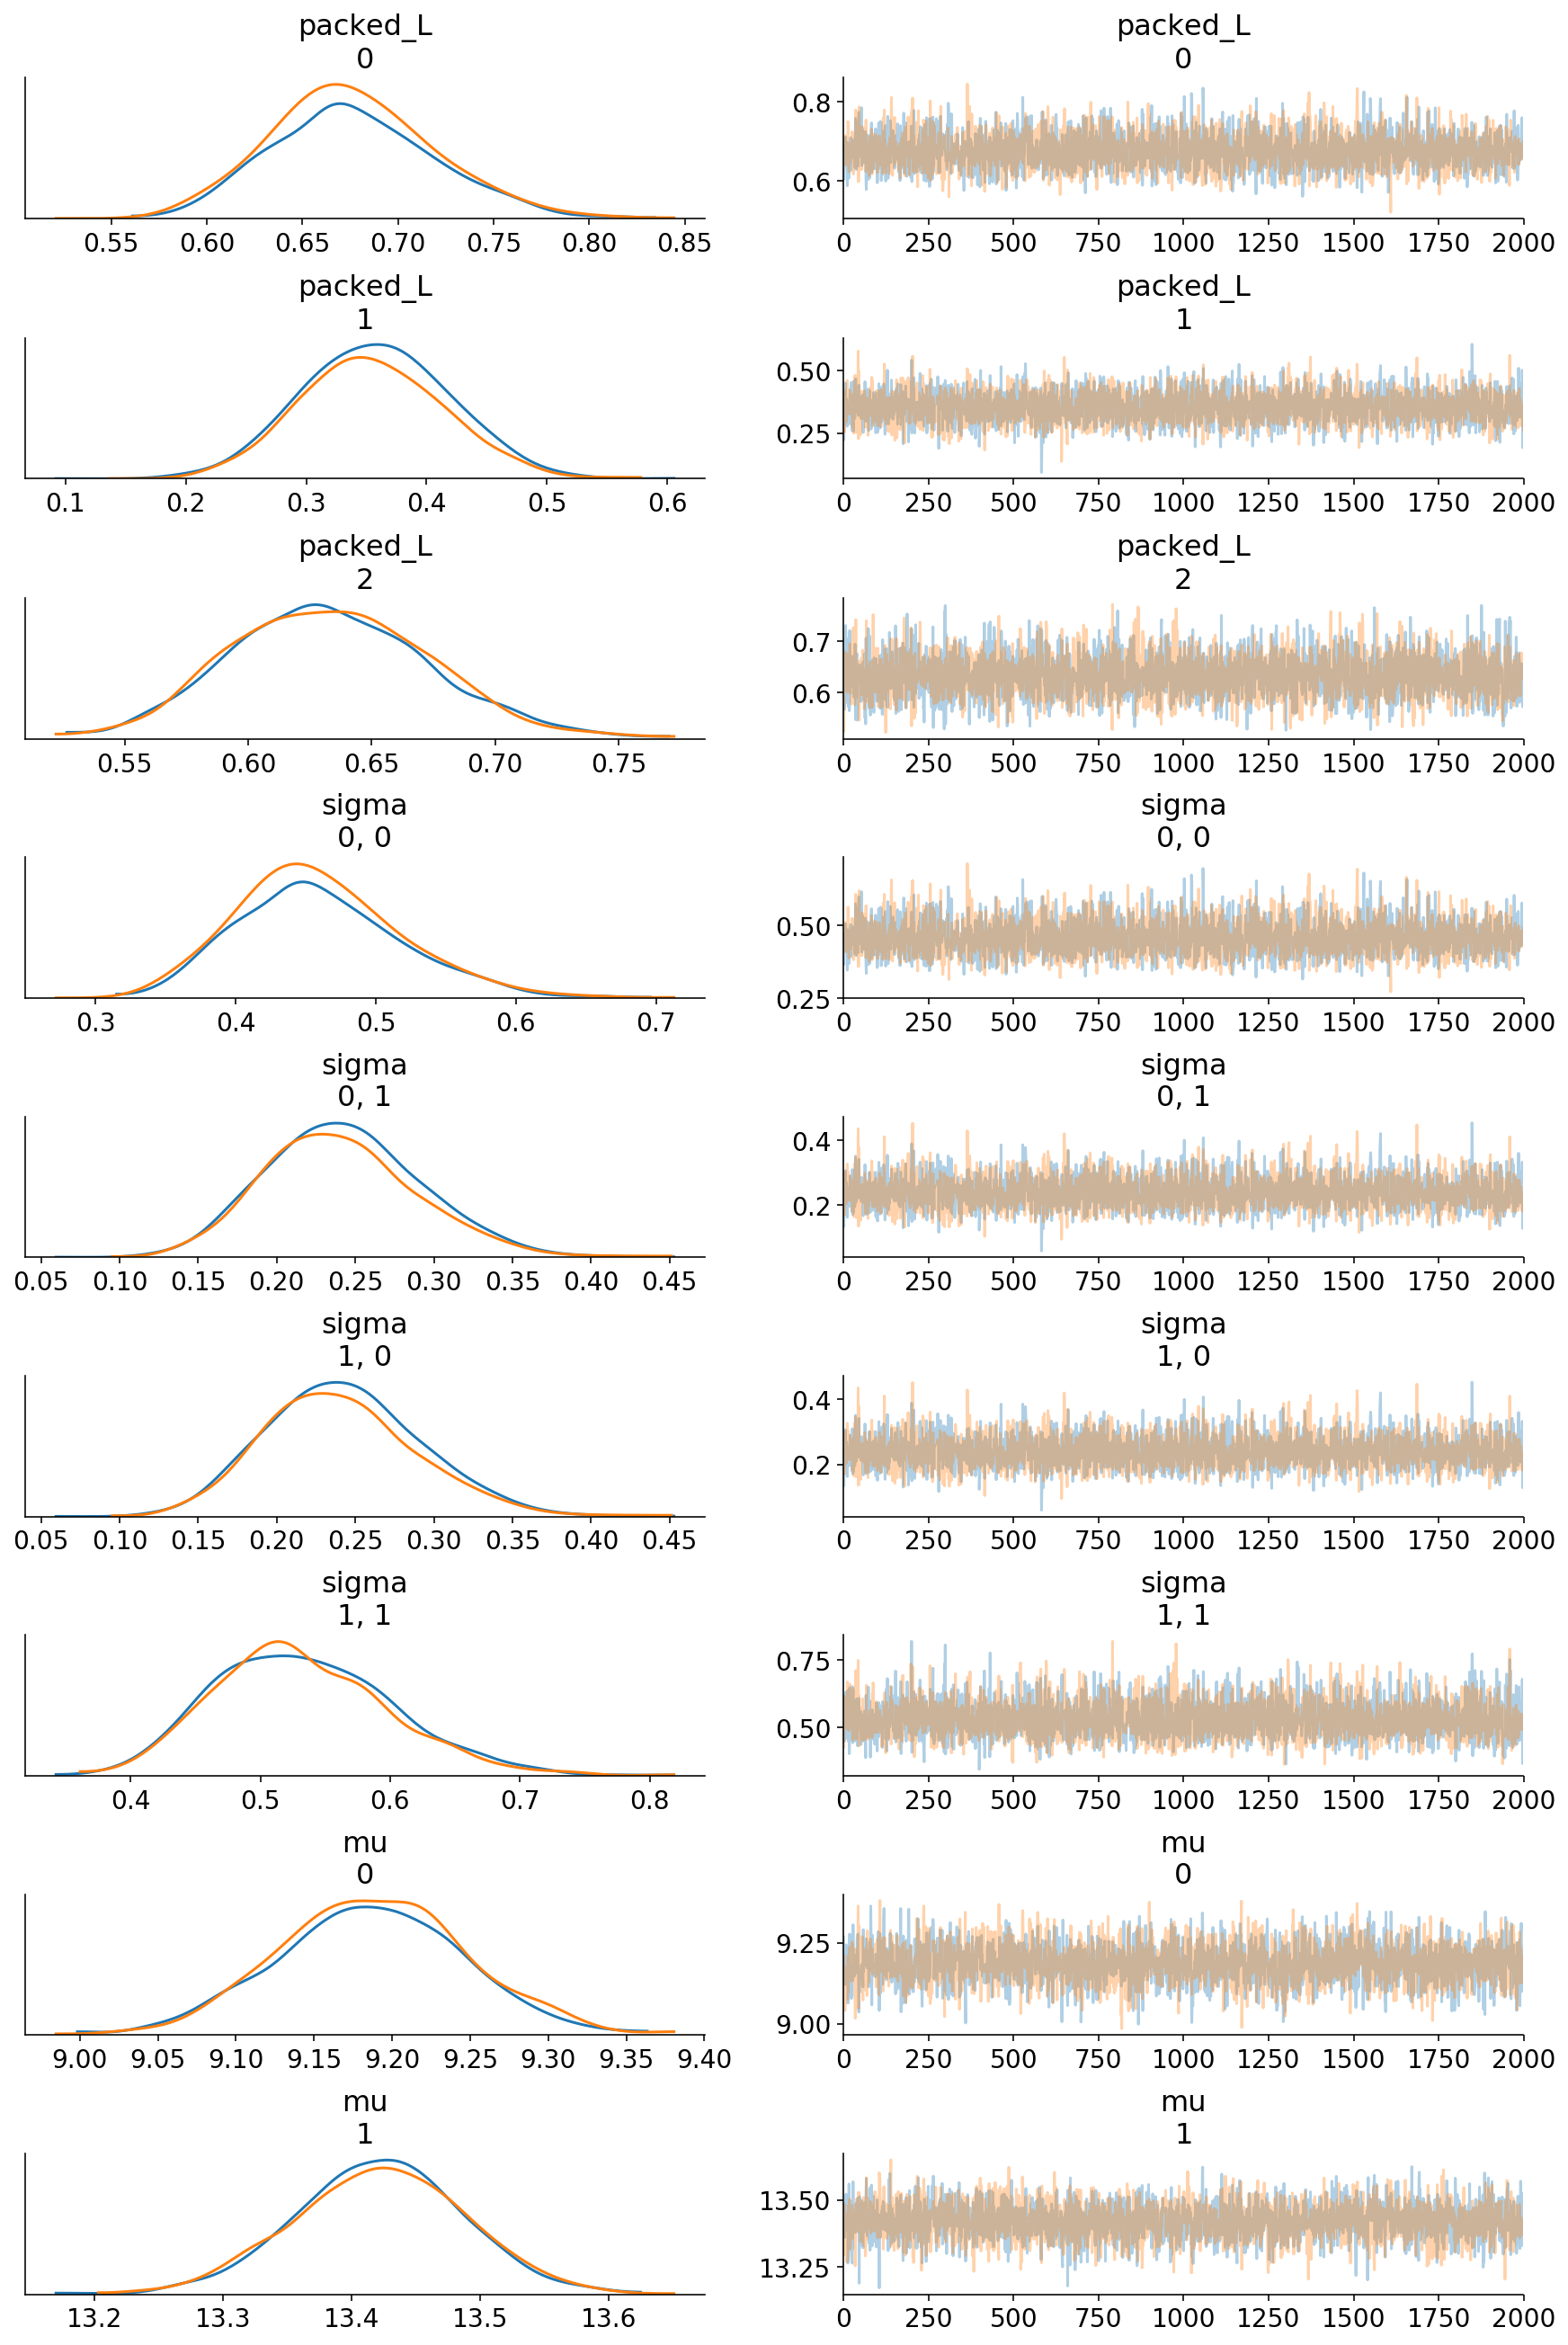

In [16]:
az.plot_trace(trace_mv)

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


(<Figure size 432x345.6 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c90addc88>],
       dtype=object))

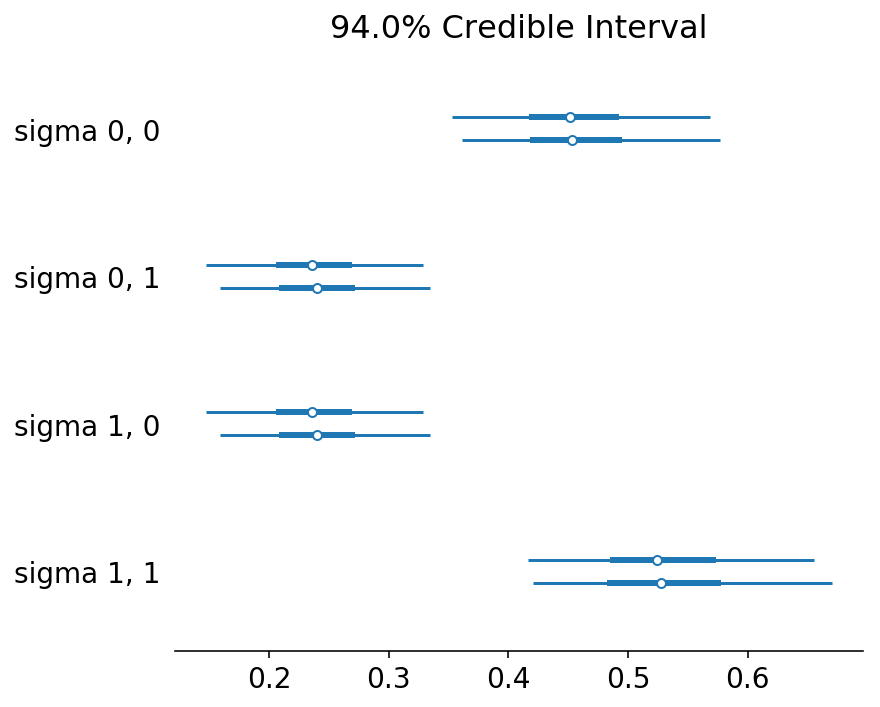

In [17]:
az.plot_forest(trace_mv, var_names=['sigma'])

(<Figure size 432x316.8 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c911d7860>],
       dtype=object))

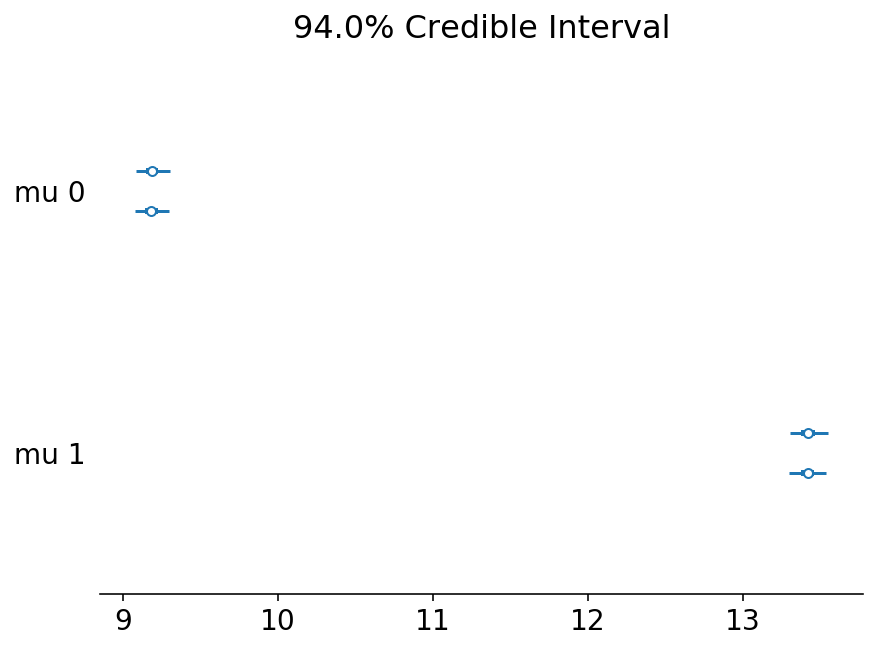

In [19]:
az.plot_forest(trace_mv, var_names=['mu'])

In [20]:
samples_mv = pm.sample_ppc(trace_mv, model=mv_beaks)

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 4000/4000 [00:02<00:00, 1585.12it/s]


In [21]:
samples_mv['like'][:, 0]  # beak_depth
samples_mv['like'][:, 1]  # beak_length

array([12.07665161, 13.41166322, 12.53547667, ..., 12.59547474,
       13.13997337, 14.82306808])

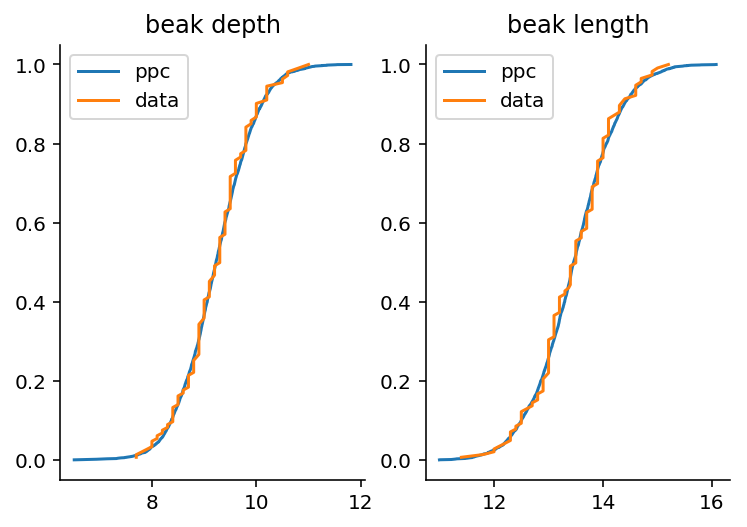

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x, y = ECDF(samples_mv['like'][:, 0])
ax1.plot(x, y, label='ppc')
x, y = ECDF(df.iloc[scandens_idx]['beak_depth'])
ax1.plot(x, y, label='data')
ax1.set_title('beak depth')
ax1.legend()

x, y = ECDF(samples_mv['like'][:, 1])
ax2.plot(x, y, label='ppc')
x, y = ECDF(df.iloc[scandens_idx]['beak_length'])
ax2.plot(x, y, label='data')
ax2.set_title('beak length')
ax2.legend()

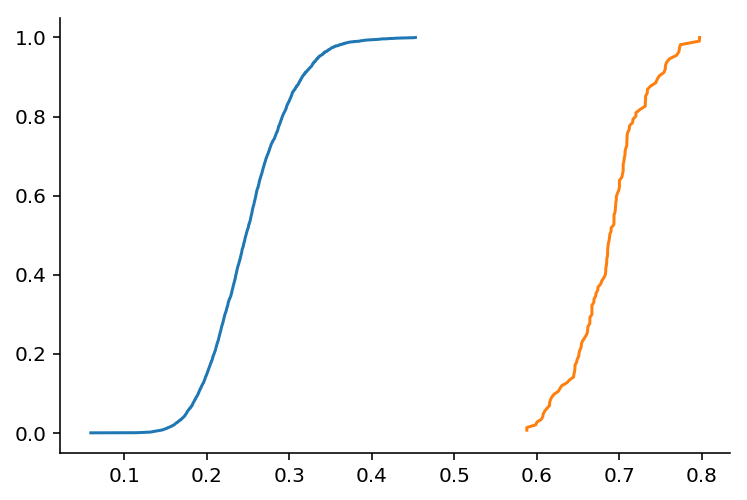

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

x, y = ECDF(trace_mv['sigma'][:, 0, 1])
ax.plot(x, y, label='samples')
x, y = ECDF(df.iloc[scandens_idx]['shape'])
ax.plot(x, y)

# Model: Regress Depth on Length

Maybe the right way to compute shape is to regress depth on length, and compute the slope. After all, that's all that depth/length really is.

We will assume a model: $y=mx$, no intercept.

In [24]:
with pm.Model() as shape_model:
    shape = pm.Normal('shape', mu=0, sd=100)
    sd = pm.HalfCauchy('sd', beta=100)
    
    mu = shape * df.iloc[scandens_idx]['beak_length'].values
    
    like = pm.Normal('like', mu=mu, sd=sd, observed=df.iloc[scandens_idx]['beak_depth'].values)

In [25]:
with shape_model:
    trace_shape = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, shape]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:01<00:00, 5390.98draws/s]
The acceptance probability does not match the target. It is 0.8786913841563619, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792088522982786, but should be close to 0.8. Try to increase the number of tuning steps.


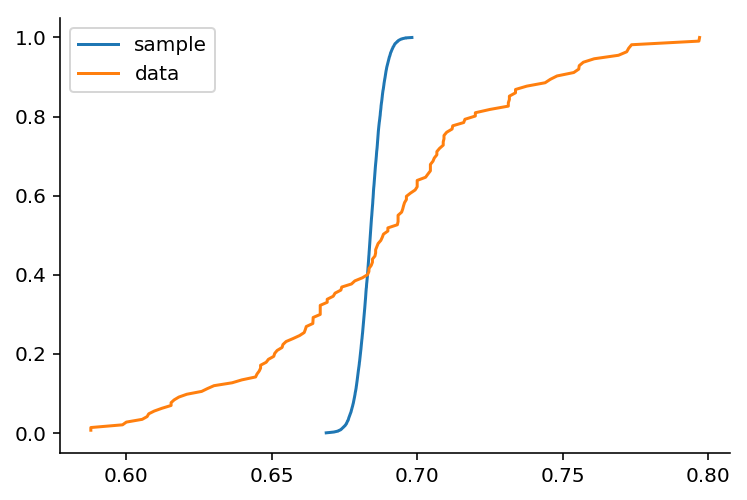

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

x, y = ECDF(trace_shape['shape'])
ax.plot(x, y, label='sample')
x, y = ECDF(df.iloc[scandens_idx]['shape'].values)
ax.plot(x, y, label='data')
ax.legend()

I have the model mis-specified - I get the posterior distribution over the slope, but not the distribution of shapes. I guess shapes and slopes are kind of different. 

Let's try just estimating shape directly.

# Model: Estimate on Shape Parameter

In [27]:
with pm.Model() as shape_model:
    mu = pm.HalfNormal('mu', sd=100)
    sd = pm.HalfCauchy('sd', beta=100)
    
    like = pm.Normal('shape', mu=mu, sd=sd, observed=df.iloc[scandens_idx]['shape'].values)

In [28]:
with shape_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 4375.48draws/s]
The acceptance probability does not match the target. It is 0.8995388352913262, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927616217400196, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923722831329716, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8908723783912403, but should be close to 0.8. Try to increase the number of tuning steps.


In [29]:
samples = pm.sample_ppc(trace, model=shape_model)

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 8000/8000 [00:02<00:00, 2970.75it/s]


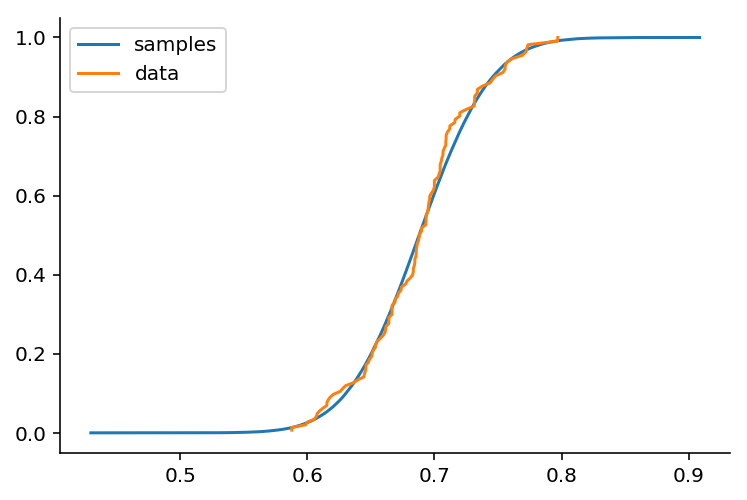

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)

x, y = ECDF(samples['shape'].flatten())
ax.plot(x, y, label='samples')
x, y = ECDF(df.iloc[scandens_idx]['shape'])
ax.plot(x, y, label='data')
ax.legend()

As it turns out, the simplest model is the best fitting one...